In [135]:
import glob
import pandas as pd
import seaborn as sns
from sklearn.metrics import auc
import matplotlib.pyplot as plt

In [40]:
from sklearn.metrics import auc
import numpy as np

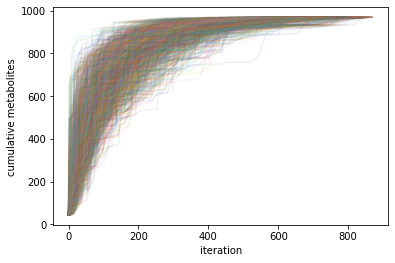

In [71]:

fold_files = glob.glob('results/fold_table/ft*')
fold_files = pd.DataFrame({'sample': [x.split('ft_')[1].split('.')[0] for x in fold_files],'fold_file': fold_files})
cpd_files = glob.glob('results/cpd_table/ct*')
cpd_files = pd.DataFrame({'sample': [x.split('ct_')[1].split('.')[0] for x in cpd_files],'cpd_file': cpd_files})
#rxn_files = glob.glob('rt*')
#rxn_files = pd.DataFrame({'sample': [x.split('_')[1].split('.')[0] for x in rxn_files],'rxn_file': rxn_files})
fold_files.set_index('sample',inplace=True)
cpd_files.set_index('sample',inplace=True)
#rxn_files.set_index('sample',inplace=True)
files = pd.concat([fold_files,cpd_files],axis=1)

dfss = []
fold_dfs = []
y = {'sample': [], 'score': []}
for sample,row in files.iterrows():
    fold = pd.read_csv(row.fold_file,index_col=0)
    fold['iteration'] = fold['iteration'] + 1
    fdf = fold.set_index('iteration')
    fdf.columns = ['fold_' + sample]
    fold_dfs.append(fdf)
    #rxn = pd.read_csv(row.rxn_file,index_col=0)
    cpds = pd.read_csv(row.cpd_file,index_col=0)
    cpds = cpds.drop('fold',axis=1).set_index('iteration').join(fold.set_index('iteration')).fillna('None').reset_index()
    cpds['count'] = 1
    dfs = cpds.groupby(['iteration','fold']).sum()
    dfs.columns = ['count_' + sample]
    dfss.append(dfs)
    df = cpds.groupby('iteration').sum().reset_index()[['iteration','count']]
    df['cumulative metabolites'] = df['count'].cumsum()
    score = auc(df['iteration'].values,df['cumulative metabolites'].values) / (969*871)
    y['sample'].append(sample)
    y['score'].append(score)
    sns.lineplot(x='iteration',y='cumulative metabolites',data=df,alpha=0.1)

In [62]:
y = pd.DataFrame(y)

In [75]:
F = []
for f in fold_dfs:
    sid = list(f)[0].split('_')[1]
    f = f.reset_index();
    f.columns = [sid,'fold']
    f.set_index('fold',inplace=True)
    F.append(f)

In [76]:
fold_df = pd.concat(F,axis=1)

In [81]:
scores = pd.DataFrame(y).set_index('sample')

In [85]:
fdf = fold_df.T.join(scores)

In [88]:
folds = list(fold_df.T)

In [95]:
from scipy.stats import pearsonr,spearmanr

In [98]:
cstats = {'fold': [], 'r': [], 'pvalue': []}
for fold in folds:
    r,p = spearmanr(fdf[fold].values,fdf['score'])
    cstats['fold'].append(fold)
    cstats['r'].append(r)
    cstats['pvalue'].append(p)
    
cstats = pd.DataFrame(cstats)

In [101]:
cstats.sort_values('r')

,fold,r,pvalue
319,381,-0.098029,1.912174e-03
382,4958,-0.095613,2.472403e-03
6,304,-0.088302,5.200871e-03
44,225,-0.082779,8.820505e-03
617,4146,-0.082343,9.185059e-03
...,...,...,...
579,7552,0.088915,4.895854e-03
53,4076,0.092522,3.406818e-03
797,2004,0.198110,2.620634e-10
591,232,0.254736,2.821707e-16


<AxesSubplot:xlabel='2004', ylabel='score'>

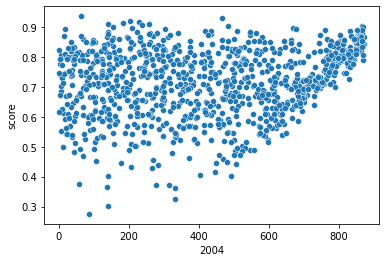

In [105]:
sns.scatterplot(x='2004',y='score',data=fdf)

In [19]:
#g = pd.concat([y.reset_index()[['fold'] + list(y)].set_index('fold') for y in dfss],axis=1).fillna(0)

In [119]:
gmean = g.T.mean().sort_values()

In [126]:
gmean = gmean.drop(['PDBChainNotFound','None'])

In [130]:
gmean = pd.DataFrame(gmean).reset_index()
gmean.columns = ['fold','mean burst size']

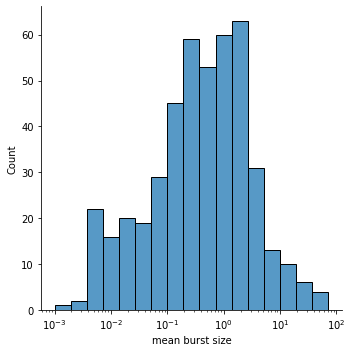

In [138]:
sns.displot(gmean,x = 'mean burst size',log_scale=10)

In [148]:
x_name = pd.read_csv('../../networkExpansionPy/assets/ecode/xid2xname.txt',sep='\t')
x_name.columns = ['fold','name']
x_name['fold'] = x_name['fold'].apply(str)

In [157]:
gmean = gmean.set_index('fold').join(x_name.set_index('fold'))

In [161]:
gmean = gmean.sort_values('mean burst size',ascending=False)

In [174]:
gmean.iloc[0:10]

,mean burst size,name
fold,,
2002,71.844,TIM beta/alpha-barrel
304,48.634,Alpha-beta plaits
2007,41.843,Flavodoxin-like
2003,40.301,Rossmann-like
2004,27.727,P-loop domains-like
230,26.423,T-fold
10,24.741,jelly-roll
11,24.406,Immunoglobulin-like beta-sandwich
2006,19.928,HAD domain-like


In [171]:
N_folds = 871
h_per_simulation = 3/N_folds
N_sims = np.array(range(0,N_folds)).sum()

In [177]:
# 2 months
from networkExpansionPy.folds import FoldRules
fold_rules = FoldRules()
fold_rules.setRules()

In [211]:
import networkExpansionPy.lib as ne

metabolism = ne.GlobalMetabolicNetwork()
metabolism.convertToIrreversible()

# remove all O2 dependent reactions
oxygen_dependent_rxns = metabolism.network[metabolism.network.cid.isin(['C00007'])].rn.unique().tolist()
o2_independent_rxns = [x for x in metabolism.network.rn.unique().tolist() if x not in oxygen_dependent_rxns]

# only keep anaerobic reactions
metabolism.subnetwork(o2_independent_rxns)

In [215]:
mrxns = metabolism.network.rn.unique().tolist()

,ec_3l,rule,rn,fold_sets
0,1.1.1,166_2003_298,R07105,"{2003, 166, 298}"
1,1.1.1,166_2003_298,R00623,"{2003, 166, 298}"
2,1.1.1,166_2003_298,R00754,"{2003, 166, 298}"
3,1.1.1,166_2003_298,R02124,"{2003, 166, 298}"
4,1.1.1,166_2003_298,R02878,"{2003, 166, 298}"
...,...,...,...,...
443831,7.2.1,1_187_221_325_3518_3921_4335_5049_7514,R09739,"{4335, 187, 5049, 3518, 1, 221, 3921, 325, 7514}"
443832,7.2.4,2486,R09509,{2486}
443833,7.2.4,2486,R12212,{2486}
443834,7.2.4,2486,R03028,{2486}


In [189]:
rxn_numbers = [];
for f,row in gmean.iterrows():
    rn_num = len(fold_rules.rules[fold_rules.rules.fold_sets.apply(lambda x: f in x)]['rn'].unique())
    rxn_numbers.append(rn_num)

In [191]:
gmean['rn_num'] = rxn_numbers

Text(0.5, 0, 'reaction scope (fold)')

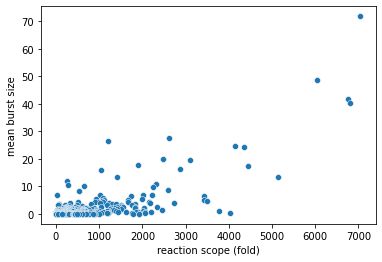

In [196]:
sns.scatterplot(x='rn_num',y='mean burst size', data = gmean)
plt.xlabel('reaction scope (fold)')

In [244]:
rxns_enabled = [len(fold_rules.folds2reactions(set([x]))) for x in  gmean.index.get_level_values(0).tolist()]

In [245]:
gmean['rxnsEnabled'] = rxns_enabled

Text(0.5, 0, 'reactions enabled with fold')

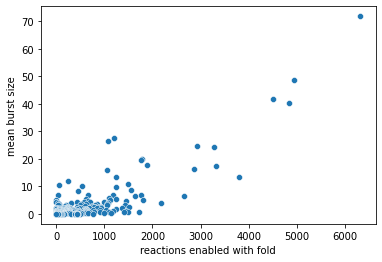

In [246]:
sns.scatterplot(x='rxnsEnabled',y='mean burst size', data = gmean)
plt.xlabel('reactions enabled with fold')

In [218]:
fr = fold_rules.copy()

In [223]:
fr.rules = fr.rules[fr.rules.rn.isin(o2_independent_rxns)]

In [242]:
gmean.loc['7541']

mean burst size              0.326
name                     NO_X_NAME
rn_num                         114
rxnsEnabled                   5183
rxnsEnabled_anaerobic         3352
Name: 7541, dtype: object

In [283]:
rxns_enabled_an = [len(fr.folds2reactions(set([x]))) for x in  gmean.index.get_level_values(0).tolist()]

In [289]:
gmean['rxnsEnabled_anaerobic'] = rxns_enabled_an

Text(0.5, 0, 'reactions enabled with fold')

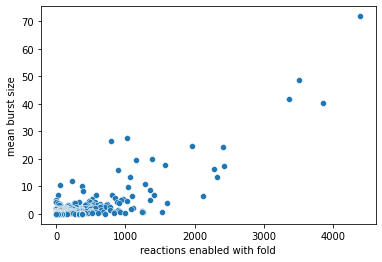

In [290]:
sns.scatterplot(x='rxnsEnabled_anaerobic',y='mean burst size', data = gmean)
plt.xlabel('reactions enabled with fold')

In [298]:
gmean.loc['304']

mean burst size                     48.634
name                     Alpha-beta plaits
rn_num                                6046
rxnsEnabled                           4942
rxnsEnabled_anaerobic                 3500
Name: 304, dtype: object